# APMAE 4990 Introduction to Data Science in Industry Final Project
## Topic: New York City Taxi Trip Duration
**Group member**: Quan Yuan (qy2205), Haokun Dong (hd2406), Lu Qiao (lq2163)

## Github repo structure
1. **`data` folder:** 2016 hourly weather data (hourly_weather.csv), final test dataset (APM4990_final_test_data_filtered.csv)
2. **`models` folder:** include all trained machine learning models (GBDT, DNN, XGBoost, Ridge, Random Forest)  
3. **`NYC_taxi_travel_time_predict_app` folder:** web application based on python plotly Dash (Flask-based framework), please notice that we don't deploy this app in pythonanywhere since running this app need Python XGBoost package which cannot be freely installed in pythonanywhere/Heroku/Plotly
4. **`script` folder:** 4 `model_name_train.py` files for training the model (we use incremental learning approach when training DNN and XGBoost model), 1 `predict_test.py` file for predicting the final test  
5. **`4990_final_project.ipynb/html` file:** a report for this final project
6. **`4990_final_pred_new.csv` file:** a prediction result for the final test set
7. **`README.md` file:** README.md for the final project

## Introduction
Our goal is to build a model which will accurately predict the travel time of a taxi trip in New York City.  
**Data Source:**  
1. 2016 NYC Taxi Data from Google Bigquery (16385532 rows)  
2. 2016 hourly weather data (we can only find hourly data in 2016, but the test set is in 2015. So when we deployed the model, we drop the weather features since we believe that it is not right to use daily weather feature since you can only use yesterday weather to predict today's taxi travel time for avoiding information leakage)

### import packages

In [3]:
# data manipulation packags
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt

# visualization
from matplotlib import pyplot as plt
import seaborn as sns

# feature engineering
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# feature selection
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

# modeling
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_log_error

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2

# module coded by ourselves
import module.pybigquery as query_reader
from module.feature_eng import Geotransform
from module.feature_eng import second_to_day
from module.feature_eng import ft_haversine_distance
from module.feature_eng import ft_degree
import module.fare_predict as fp

# ignore warning
import warnings
warnings.filterwarnings('ignore')

## 1. Data Gathering and Preparation

### 1.1 Data pipeline

**query taxi data from Google BigQuery**

In [6]:
# choose the features we want to import from Bigquery
# please note we only used the data loaded from this query to do experiments, we used more data to train the model
taxi_query = (
    """SELECT 
    pickup_longitude,
    pickup_latitude,
    pickup_datetime,
    dropoff_longitude,
    dropoff_latitude,
    trip_distance,
    passenger_count,
    DATETIME_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`
    LIMIT 100000"""
)

In [26]:
# Import 100000 data from Bigquery
taxi_data = query_reader.read_data(taxi_query)
# drop NAs
taxi_data = taxi_data.dropna() 
# sort the data by pickup_datetime
taxi_data = taxi_data.sort_values(by = "pickup_datetime") 
taxi_data.head()

,pickup_longitude,pickup_latitude,pickup_datetime,dropoff_longitude,dropoff_latitude,trip_distance,passenger_count,travel_time
11718,-73.789848,40.646961,2016-01-01 00:04:43,-73.927505,40.760677,14.42,1,1236
41603,-73.788948,40.647720,2016-01-01 00:13:41,-73.837440,40.714729,7.27,5,899
11122,-73.970551,40.756367,2016-01-01 00:14:07,-73.939384,40.853710,8.61,2,938
7537,-73.983009,40.771782,2016-01-01 00:17:51,-73.897095,40.701279,8.35,1,2029
35074,-73.976608,40.766071,2016-01-01 00:19:17,-74.010162,40.704967,7.21,5,1010


**Question:** How easy is it to fetch new data and retrain your model?  
**Answer:** Two models we trained (XGBoost, DNN) support incremental learning. Actually, we used incremental learning approach to train those two models. We trained XGBoost model with 6 million rows data, 20 epochs, 300K rows for each epoch; DNN model with 15 million rows, 50 epochs, 300K rows for each epoch. However, for ridge, random forest and GBDT, we need to retrain the model with the whole dataset. The good thing is that you don't need to write too much code for training a new model, we wrapped almost all data loading, data cleaning, feature enginnering, modeling works into our module. You can easily use it. Please refer to the `script` folder, you could see how we use the script to train the model. All you need to do is to change the train set!

### Join hourly weather data with Taxi data from Google BigQuery

**weather data**  
**Data Source:** https://www.kaggle.com/meinertsen/new-york-city-taxi-trip-hourly-weather-data  
After exploring, we used the following features: "pickup_datetime", "tempi", "dewpti", "hum", "wspdm", "wdird", "wdire", "vism", "pressurem", "precipm", "conds", "icon", "fog", "rain", "snow", "hail", "thunder", "tornado"  
**join method:** search for prior, and join based on the nearest key 

In [27]:
# tempi: Temperature in Fahrenheit
# dewpti: Dewpoint in Fahrenheit
# hum: Humidity %
# wspdm: Wind speed in kph
# wdird: Wind direction in degrees
# wdire: Wind direction description
# vism: Vivibility in Km
# pressurem: Pressure in mBar
# precipm: Precipitation in mm (fill NA with 0)
# conds: Conditions
# icon
# fog: Boolean
# rain: Boolean
# snow: Boolean
# hail: Boolean
# thunder: Boolean
# tornado: Boolean
features = ["pickup_datetime", "tempi", "dewpti", "hum", "wspdm", "wdird", "wdire", \
            "vism", "pressurem", "precipm", "conds", "icon", "fog", "rain", "snow", "hail", \
            "thunder", "tornado"] # name the weather features

In [28]:
# the weather data of New York in 2016
weather_data = pd.read_csv("data/hourly_weather.csv", usecols = features) 
weather_data['pickup_datetime'] = weather_data['pickup_datetime'].map(lambda x: \
                                                    dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
weather_data = weather_data.sort_values(by = "pickup_datetime")
# join the taxi data with weather data
# join method: search for prior, and join based on the nearest key 
taxi_data = pd.merge_asof(taxi_data, weather_data, on = "pickup_datetime")

**Comment:** We joined the weather data which we thought would have good predicting power. Since we only have the weather data for 2016, we might choose to drop the weather features if the test set is not in year 2016.

* fillna  
ffill method: propagate last valid observation forward to next valid backfill  
use ffill method for features: tempi, dewpti, hum, wspdm, vism, pressurem  
use 0 for features: precipm  

In [29]:
taxi_data["precipm"] = taxi_data["precipm"].fillna(0)
taxi_data = taxi_data.fillna(method = "ffill")

* check NA for the whole dataset

In [30]:
sum(taxi_data.isna().sum())

0

### 1.2 Data integrity checks

Notice that, in this part, we use trip_distance and travel_time for helping clean data. We only use pickup latitude, pickup longtitude, dropoff latitude, dropoff longtitude and pickup time 5 columns to train out model (for the final deployed model, but in this notebook, we also used weather features and passenger count)

**What we did for cleaning data?**  

1. **checking latitude and longtitude**: we believe the data is not valid if both latitude and longtitude are equal to zero. Based on this assumption, we removed data with 0 latitude and 0 longtitude.  
2. **checking taxi speed**: we get the highest car speed in the world, we believe NYC taxi cannot surpass that. Based on this assumption, we removed data if the car speed > the highest car speed in the world.  
3. **checking trip distance**: we drop the data if trip_distance is equal to 0.  
4. **checking outliers**: we plot a scatter graph for latitude and longtitude. And we defined a range for longtitude (-75 to -72)
5. **checking NA**: we already dropped NA in the former section

#### (1) drop lat = 0 and long = 0

In [31]:
# original length
print(len(taxi_data))

52551


In [32]:
 #drop abnormal data
taxi_data = taxi_data[(taxi_data['pickup_longitude'] != 0) &\
                      (taxi_data['pickup_latitude'] != 0) & \
                      (taxi_data['dropoff_longitude'] != 0) & \
                      (taxi_data['dropoff_latitude'] != 0)]         

In [33]:
# check the length
print(len(taxi_data)) 

51518


#### (2) remove outlier based on fastest speed

In [34]:
# possible fastest speed limit
fastest = 268/60/60 

In [35]:
# drop those data out of possible speed limit
print("remove {0} rows".format(sum(taxi_data['trip_distance']/taxi_data['travel_time']>fastest)))
taxi_data = taxi_data[taxi_data['trip_distance']/taxi_data['travel_time'] < fastest] 

remove 68 rows


In [36]:
# check the length
print(len(taxi_data)) 

51449


#### (3) remove trip_distance <= 0

In [37]:
 # distance must be positive
taxi_data = taxi_data[taxi_data['trip_distance'] > 0]

In [38]:
#check the length of data
print(len(taxi_data))

50994


#### (4) drop outliers for longitude, latitude

In [39]:
# drop outliers
taxi_data = taxi_data[(taxi_data['dropoff_longitude'] > -75) &\
                      (taxi_data['dropoff_longitude'] < -72)]
taxi_data = taxi_data[(taxi_data['pickup_longitude'] > -75) &\
                      (taxi_data['pickup_longitude'] < -72)]

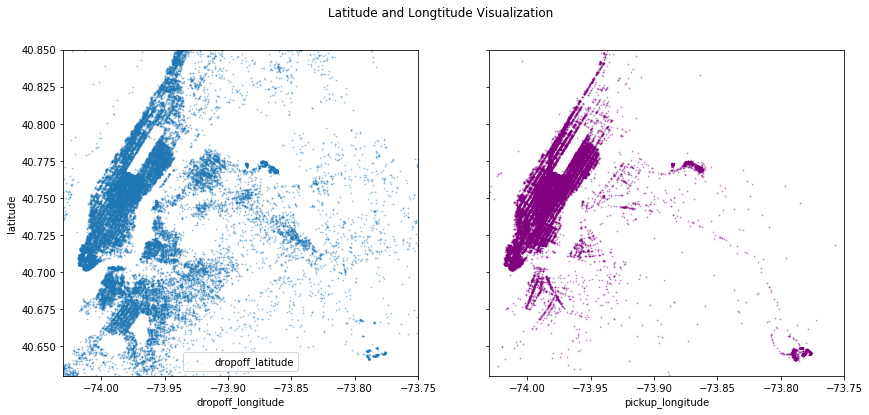

In [68]:
# visualization
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(figsize = (14, 6), ncols=2, sharex=True, sharey=True)
ax[0].scatter(taxi_data['dropoff_longitude'], taxi_data['dropoff_latitude'], s=1, alpha=0.3)
ax[1].scatter(taxi_data['pickup_longitude'], taxi_data['pickup_latitude'], s=1, alpha=0.3, color='purple')
fig.suptitle('Latitude and Longtitude Visualization')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('dropoff_longitude')
ax[1].set_xlabel('pickup_longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

**Question 1**: Is there information leakage? ie. a variable which is actually inferred by the outcome (eg. predicting a user likes a movie using the fact that they've liked that movie before).


**Question 2**: Are some variables non-sensical or redundant? (ie. if you see "Male" sometimes and "M" other times, or numerical values in the gender column)

### 1.3 Feature enginnering

**What we did in feature enginnering?**  

1. **log transformation for travel time**
2. **calculate haversine distance**
3. **calculate direction**
4. **getting time series information**
5. **onehot encoding for categorical features**
5. **predict total fare**

Did you convert categorical features into one hot encoded dummy variables?  
Did you properly transform variables appropriate for the model type? (eg. how do you deal with lat/lngs in a linear model?)  
Was there an opportunity to make a new variable from the old ones that has more predictive power?  
Do you join the data to any other interesting data sets that have useful predictive power?  
Do you standardize variables when necessary?  

#### (1) log transformation for travel time

In [69]:
#log-transformation for target value
taxi_data["travel_time"] = taxi_data["travel_time"].map(np.log) 

**Comment:** Use log tranformation to improve the normality of target variable.

#### (2) calculate distance

In [70]:
# use lat and lng to calculate distance
dist2 = ft_haversine_distance(taxi_data['pickup_latitude'].values,
                              taxi_data['pickup_longitude'].values,
                              taxi_data['dropoff_latitude'].values,
                              taxi_data['dropoff_longitude'].values) 

**Comment:** We transform lat and lng into distance so that we properly transformed variables appropriate for the model type. It is a decent way to deal with lat and lng data, we can fit our model with distance instead.

In [71]:
 #check the correaltion between the true distance and the distance we calculated
print(np.corrcoef(taxi_data['trip_distance'], dist2))

[[1.         0.87832951]
 [0.87832951 1.        ]]


In [72]:
taxi_data['distance'] = dist2 # create a new distance feature

#### (3) degree

In [73]:
 # calculate the angel related with pickup and dropout locations
degree = ft_degree(taxi_data['pickup_latitude'].values,
                   taxi_data['pickup_longitude'].values,
                   taxi_data['dropoff_latitude'].values,
                   taxi_data['dropoff_longitude'].values)

In [74]:
# create a new degree feature
taxi_data['degree'] = degree 

**Comment:** More features will improve the predicting power of our model.

#### (4) time series information

In [75]:
# deal with datatime data, convert into other variables
taxi_data['month'] = taxi_data['pickup_datetime'].map(lambda x: x.month)
taxi_data['weekday'] = taxi_data['pickup_datetime'].map(lambda x: x.weekday())
taxi_data['day'] = taxi_data['pickup_datetime'].map(lambda x: x.day)
taxi_data['hour'] = taxi_data['pickup_datetime'].map(lambda x: x.hour)
taxi_data['minute'] = taxi_data['pickup_datetime'].map(lambda x: x.minute)
taxi_data['minute_oftheday'] = taxi_data['hour'] * 60 + taxi_data['minute'] 

**Comment:** Variable pickup_datatime is diffcult to use for constructing model, so we dicided to refine it and creat more features.

#### (5) categorical features

In [76]:
# check data types
taxi_data.dtypes 

pickup_longitude            float64
pickup_latitude             float64
pickup_datetime      datetime64[ns]
dropoff_longitude           float64
dropoff_latitude            float64
trip_distance               float64
passenger_count               int64
travel_time                 float64
tempi                       float64
dewpti                      float64
hum                         float64
wspdm                       float64
wdird                         int64
wdire                        object
vism                        float64
pressurem                   float64
precipm                     float64
conds                        object
icon                         object
fog                           int64
rain                          int64
snow                          int64
hail                          int64
thunder                       int64
tornado                       int64
distance                    float64
degree                      float64
month                       

In [77]:
# wdire, conds, icon
# wdire
newtaxi_data = pd.concat([taxi_data, pd.get_dummies(taxi_data['wdire'])], axis = 1)
newtaxi_data = pd.concat([newtaxi_data, pd.get_dummies(newtaxi_data['conds'])], axis = 1)
newtaxi_data = pd.concat([newtaxi_data, pd.get_dummies(newtaxi_data['icon'])], axis = 1)
newtaxi_data.drop(['wdire'], axis = 1, inplace = True)
newtaxi_data.drop(['conds'], axis = 1, inplace = True)
newtaxi_data.drop(['icon'], axis = 1, inplace = True)

**Comment:** Here we convert categorical features into one hot encoded dummy variables. This allows the model to assume a natural ordering between categories may result in poor performance or unexpected results.

#### (6) fee

In [78]:
# use the model we trained to predict the fare amount
newtaxi_data['fare_predict'] = fp.fare_gbm(taxi_data.loc[:, ['pickup_longitude','pickup_latitude','pickup_datetime','dropoff_longitude','dropoff_latitude',"passenger_count"]])

**Comment:** This is not information leakage. We did not use the fare amount data directly, instead we fitted a XGboost model and predict the values using the variables we had in test set. We created this new feature which is important in our further analysis.

## 2. Model Selection, Comparison and Cross Validation

### 2.1 Exploratory Analysis

Did you analyze the features and how they are related to the outcome variable? (eg. scatter plots, histograms).  
Did you look at correlations or chi-squared if the variables are categorical? (https://en.wikipedia.org/wiki/Chi-squared_test. But feel free to find a package that does this automatically).

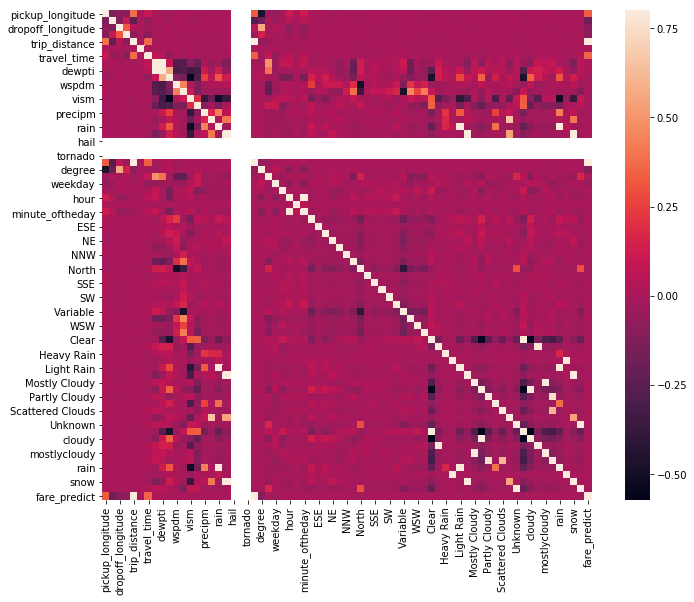

In [79]:
 # check the correlation heatmap
corrmat = newtaxi_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

**Comment:** We can observe that trip distance and predicted fare amount have a positive correlation with the traval time.

Most of the weather features have no correlation or negative correlation with travel time. And some of those features have problem of multicollinearity.

What suprises us is that pickup_longitude is actually correlated with travel time, so we need take a close look at this feature.

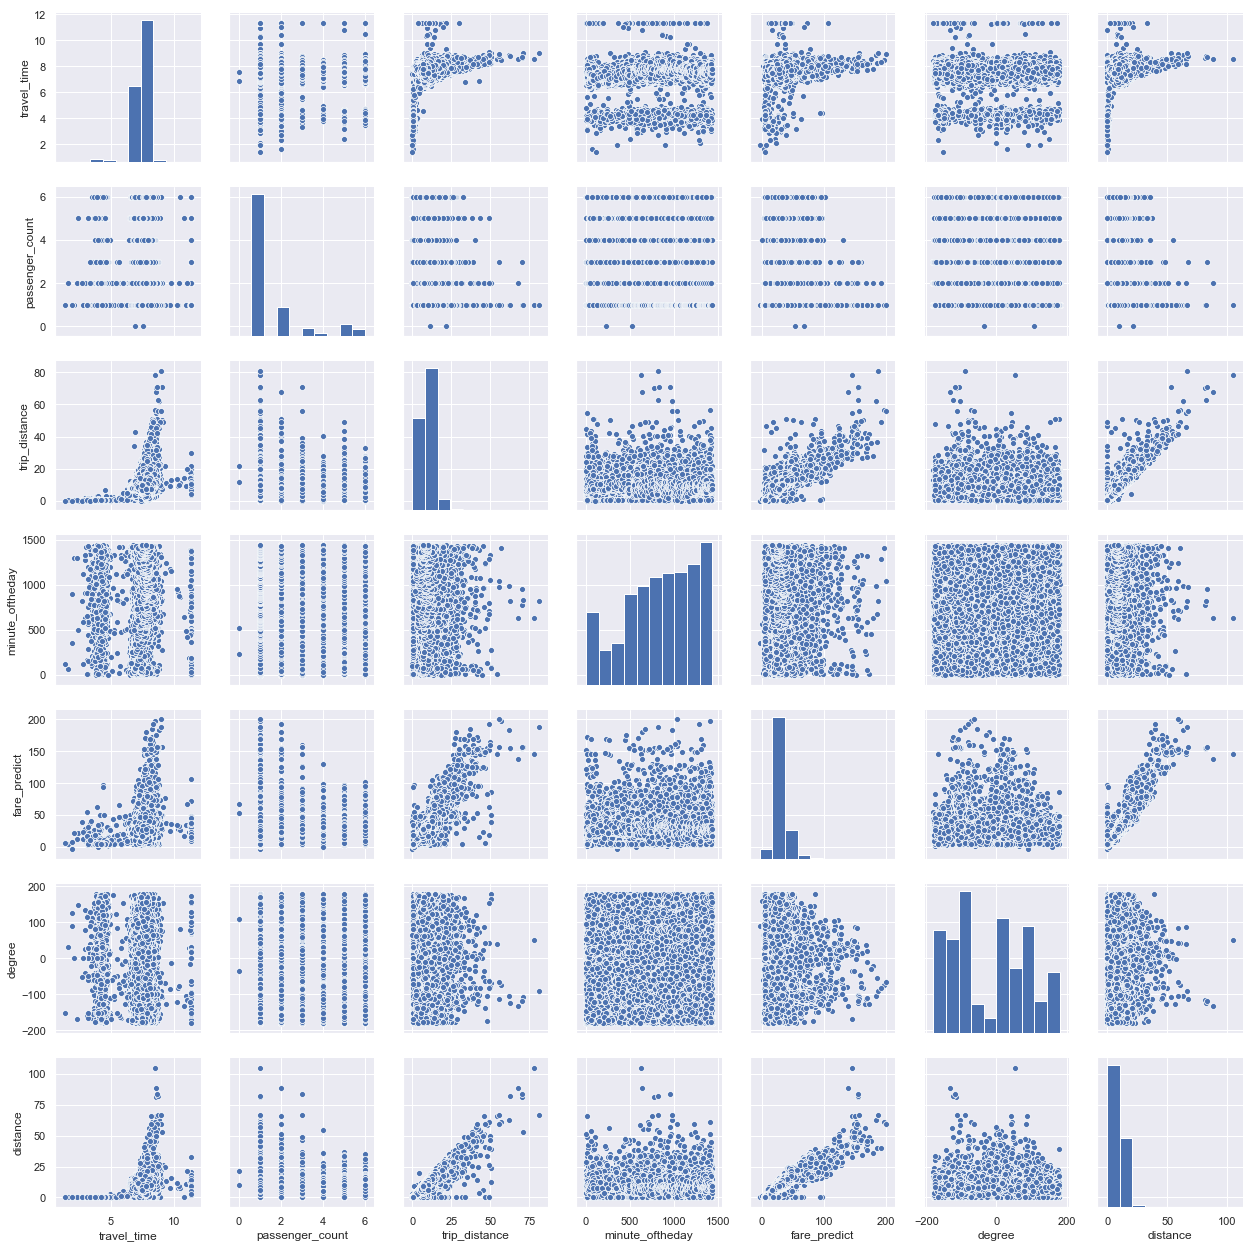

In [80]:
# check the scatter plots between features and our target variables
sns.set()
cols = ['travel_time','passenger_count','trip_distance', 'minute_oftheday','fare_predict','degree','distance']
sns.pairplot(newtaxi_data[cols], size = 2.5)
plt.show() 

**Comment:** It shows that trip_distance and fare_predict have some positive relationships with travel time. We will consider them as some important features.

Trip_distance and distance share a similar relationship with travel time which makes sense. We also can observe this phenomenon among minute_oftheday and degree.

### 2.2 Feature Selection

In [81]:
#check our features
newtaxi_data.columns 

Index(['pickup_longitude', 'pickup_latitude', 'pickup_datetime',
       'dropoff_longitude', 'dropoff_latitude', 'trip_distance',
       'passenger_count', 'travel_time', 'tempi', 'dewpti', 'hum', 'wspdm',
       'wdird', 'vism', 'pressurem', 'precipm', 'fog', 'rain', 'snow', 'hail',
       'thunder', 'tornado', 'distance', 'degree', 'month', 'weekday', 'day',
       'hour', 'minute', 'minute_oftheday', 'ENE', 'ESE', 'East', 'NE', 'NNE',
       'NNW', 'NW', 'North', 'SE', 'SSE', 'SSW', 'SW', 'South', 'Variable',
       'WNW', 'WSW', 'West', 'Clear', 'Haze', 'Heavy Rain',
       'Light Freezing Rain', 'Light Rain', 'Light Snow', 'Mostly Cloudy',
       'Overcast', 'Partly Cloudy', 'Rain', 'Scattered Clouds', 'Snow',
       'Unknown', 'clear', 'cloudy', 'hazy', 'mostlycloudy', 'partlycloudy',
       'rain', 'sleet', 'snow', 'unknown', 'fare_predict'],
      dtype='object')

In [82]:
# get X and Y
X = newtaxi_data.drop(["trip_distance", "travel_time", "pickup_datetime", "minute"], axis = 1)
y = newtaxi_data[["travel_time"]].values.ravel() 

#### (1) Random Forest

In [83]:
 #feature selection by random forest
rf_regressor = RandomForestRegressor(n_estimators=20, random_state=0) 
rf_regressor.fit(X, y)  
fe_impo = pd.DataFrame({"features": X.columns, "importance": rf_regressor.feature_importances_})

In [94]:
# check the ranking of features
rf_rank = fe_impo.sort_values(by = "importance", ascending = False).head(30)
rf_rank.head()

,features,importance
19,distance,0.561842
65,fare_predict,0.077800
25,minute_oftheday,0.067406
0,pickup_longitude,0.036237
20,degree,0.033293


**Comment:** We used random forest regressor to obtain the feature importance ranking and demonstrate the top 30 features.

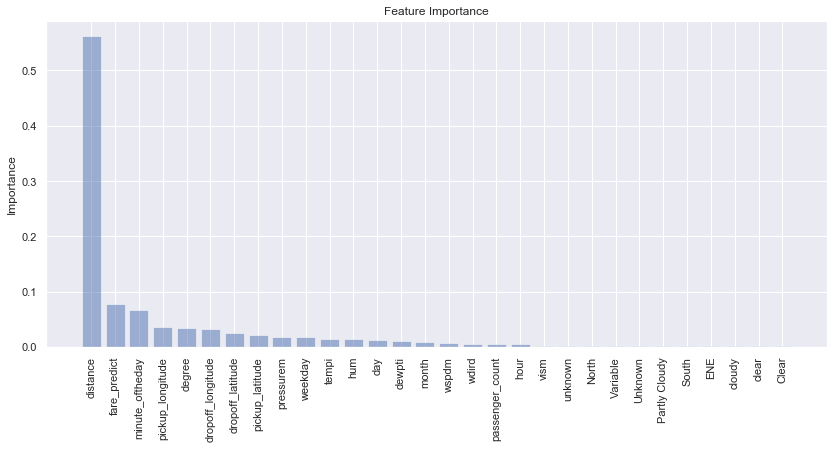

In [89]:
# Plot the feature importances of the forest
y_pos = np.arange(len(rf_rank['features']))
plt.figure(figsize=(14,6))
plt.bar(y_pos, rf_rank['importance'], align='center', alpha=0.5)
plt.xticks(y_pos, rf_rank['features'], rotation='vertical')
plt.ylabel('Importance')
plt.title('Feature Importance')

plt.show()

**Comment:** Clearly, distance has a huge influence on travel time since it has the largest feature impotance.

Fare amount predicted and minute of the day are also important but with a relatively small importance value.

The rest of features do not seem to have significant effect on our target variable.

#### (2) Step forward selection 

In [86]:
# Build RF classifier to use in feature selection
reg = linear_model.Ridge()

# Build step forward feature selection
sfs1 = sfs(reg,
           k_features = 30,
           forward = True,
           floating = False,
           verbose = 0,
           scoring = 'neg_mean_squared_error',
           cv = None)

# Perform SFFS
sfs1 = sfs1.fit(X, y)

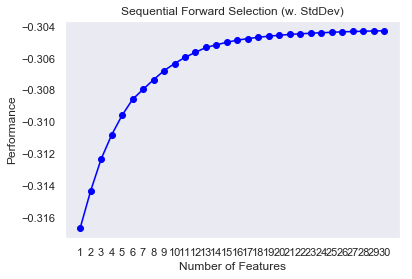

In [91]:
 # feature selection plot 
fig = plot_sfs(sfs1.get_metric_dict(), kind = 'std_dev')
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

In [93]:
fe_sfs = pd.DataFrame({"idx": sfs1.k_feature_idx_, "name": sfs1.k_feature_names_})
fe_sfs.index = fe_sfs['idx'].values

### 2.3 Model Selection

Did you randomly split your data into training and testing data (20%, 80%) using k-fold cross validation?  
Did you perform regularization Linear model: Why did you use L^1 or L^2? Decision Tree Models: Which parameters did you tune and why? I expect to see use of GridSearchCV for this with at least 3 fold cross validation.  
Did you try out various models and see which one performed best? Did you plot the comparisons of the models in a way which is digestable to the reader?  
Did you make feature importance plots and discussed their meaning or lack thereof?  

In [96]:
# newX = X[fe_impo['features'][:15].values]
newX = X[fe_sfs.loc[sfs1.subsets_[20]['feature_idx'], ]['name'].values]
y = pd.Series(y)

### 2.3.1 Baseline Ridge

In [ ]:
#Standardize
min_max_scale = MinMaxScaler()
mm_newX = min_max_scale.fit_transform(newX)

In [ ]:
def baseline_ridge(X, y, alphas, fold = 5):
    skf = KFold(n_splits = fold, shuffle = True)
    fold_num = 1
    alpha_score=[]
    train_result = []
    valid_result = []
    rMSE= []
    RMSLE = []
    #find the best alpha
    for a in alphas:
        for train_index, valid_index in skf.split(X, y):
            # dataset
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
            #train_result and find errors
            test_errors=[]
            ridge = linear_model.Ridge(alpha=a, fit_intercept = False)
            ridge.fit(X_train,y_train)
            test_errors.append(ridge.score(X_valid,y_valid))
            
        alpha_score.append(sum(test_errors) / float(len(test_errors)))   
    
    alpha_max = alphas[np.argmax(alpha_score)]
    
    #train using best alpha
    for train_index, valid_index in skf.split(X, y):
        # dataset
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        # model
        ridge = linear_model.Ridge(alpha=alpha_max, fit_intercept = False)
        ridge.fit(X_train,y_train)
        y_train_pred = ridge.predict(X_train)
        y_valid_pred = ridge.predict(X_valid)
        # result
        r2_train = metrics.r2_score(y_train, y_train_pred)
        r2_valid = metrics.r2_score(y_valid, y_valid_pred)
        rmsle_valid = np.sqrt(mean_squared_log_error(y_valid, y_valid_pred ))
        mse_train = metrics.mean_squared_error(y_train, y_train_pred)
        mse_valid = metrics.mean_squared_error(y_valid, y_valid_pred)
        rmsle_train = np.sqrt(metrics.mean_squared_log_error(y_train, y_train_pred))
        rmsle_valid = np.sqrt(metrics.mean_squared_log_error(y_valid, y_valid_pred))
        print("Fold {0} Train R2 {1}".format(fold_num, r2_train))
        print("Fold {0} Test R2 {1}".format(fold_num, r2_valid))
        print("Fold {0} Train mse {1}".format(fold_num, mse_train))
        print("Fold {0} Test mse {1}".format(fold_num, mse_valid))
        print("Fold {0} Train rmsle {1}".format(fold_num, rmsle_train))
        print("Fold {0} Test rmsle {1}".format(fold_num, rmsle_valid))
        fold_num += 1
    #train_result.append(r2_train)
    valid_result.append(r2_valid)
    rMSE.append(np.sqrt(mse_valid))
    RMSLE.append(rmsle_valid)
    return valid_result,rMSE, RMSLE

In [ ]:
ridge_result = baseline_ridge(pd.DataFrame(mm_newX), y, alphas = [1])
# R2,rMSE and RMSLE results for ridge
ridge_result  

### 2.3.2 Lasso Regression

In [ ]:
def baseline_lasso(X, y, fold = 5):
    skf = KFold(n_splits = fold, shuffle = True)
    fold_num = 1
    alpha_score=[]
    train_result = []
    valid_result = []
    rMSE= []
    RMSLE = []
    #train using best alpha
    for train_index, valid_index in skf.split(X, y):
        # dataset
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        # model
        lasso = linear_model.Lasso()
        lasso.fit(X_train,y_train)
        y_train_pred = lasso.predict(X_train)
        y_valid_pred = lasso.predict(X_valid)
        # result
        r2_train = metrics.r2_score(y_train, y_train_pred)
        r2_valid = metrics.r2_score(y_valid, y_valid_pred)
        mse_train = metrics.mean_squared_error(y_train, y_train_pred)
        mse_valid = metrics.mean_squared_error(y_valid, y_valid_pred)
        rmsle_train = np.sqrt(metrics.mean_squared_log_error(y_train, y_train_pred))
        rmsle_valid = np.sqrt(metrics.mean_squared_log_error(y_valid, y_valid_pred))
        print("Fold {0} Train R2 {1}".format(fold_num, r2_train))
        print("Fold {0} Test R2 {1}".format(fold_num, r2_valid))
        print("Fold {0} Train mse {1}".format(fold_num, mse_train))
        print("Fold {0} Test mse {1}".format(fold_num, mse_valid))
        print("Fold {0} Train rmsle {1}".format(fold_num, rmsle_train))
        print("Fold {0} Test rmsle {1}".format(fold_num, rmsle_valid))
        fold_num += 1
    #train_result.append(r2_train)
    valid_result.append(r2_valid)
    rMSE.append(np.sqrt(mse_valid))
    RMSLE.append(rmsle_valid)
    return valid_result,rMSE, RMSLE

In [ ]:
lasso_result = baseline_lasso(pd.DataFrame(mm_newX), y)
# R2,rMSE and RMSLE results for lasso
lasso_result  

### 2.3.3 Random Forest

In [97]:
def baseline_rf(X, y, fold = 5):
    skf = KFold(n_splits = fold, shuffle = True)
    fold_num = 1
    train_result = []
    valid_result = []
    rMSE = []
    RMSLE = []
    for train_index, valid_index in skf.split(X, y):
        # dataset
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        # model
        reg = GradientBoostingRegressor(n_estimators=50, random_state=0, max_depth=4, \
                                        learning_rate = 0.15, subsample = 0.8)
        reg.fit(X_train, y_train)
        y_train_pred = reg.predict(X_train)
        y_valid_pred = reg.predict(X_valid)
        # result
        r2_train = metrics.r2_score(y_train, y_train_pred)
        r2_valid = metrics.r2_score(y_valid, y_valid_pred)
        rmsle_valid = np.sqrt(mean_squared_log_error(y_valid, y_valid_pred ))
        mse_train = metrics.mean_squared_error(y_train, y_train_pred)
        mse_valid = metrics.mean_squared_error(y_valid, y_valid_pred)
        rmsle_train = np.sqrt(metrics.mean_squared_log_error(y_train, y_train_pred))
        rmsle_valid = np.sqrt(metrics.mean_squared_log_error(y_valid, y_valid_pred))
        print("Fold {0} Train R2 {1}".format(fold_num, r2_train))
        print("Fold {0} Test R2 {1}".format(fold_num, r2_valid))
        print("Fold {0} Train mse {1}".format(fold_num, mse_train))
        print("Fold {0} Test mse {1}".format(fold_num, mse_valid))
        print("Fold {0} Train rmsle {1}".format(fold_num, rmsle_train))
        print("Fold {0} Test rmsle {1}".format(fold_num, rmsle_valid))
        fold_num += 1
    #train_result.append(r2_train)
    valid_result.append(r2_valid)
    rMSE.append(np.sqrt(mse_valid))
    RMSLE.append(rmsle_valid)
    return  valid_result,rMSE, RMSLE

In [98]:
rf_result = baseline_rf(X, y)
# R2,rMSE and RMSLE results for random forest
rf_result 

Fold 1 Train R2 0.7390749816184999
Fold 1 Test R2 0.6680100004729255
Fold 1 Train mse 0.09511598432307926
Fold 1 Test mse 0.11579487048974184
Fold 1 Train rmsle 0.03789836582347818
Fold 1 Test rmsle 0.044708319468301956
Fold 2 Train R2 0.7399010479100463
Fold 2 Test R2 0.67082428015049
Fold 2 Train mse 0.0931901083600128
Fold 2 Test mse 0.12303245474812347
Fold 2 Train rmsle 0.03795033206654295
Fold 2 Test rmsle 0.045510210163300785
Fold 3 Train R2 0.7412105160078157
Fold 3 Test R2 0.644537462608757
Fold 3 Train mse 0.09311679653264263
Fold 3 Test mse 0.1306884504487587
Fold 3 Train rmsle 0.03772019573482627
Fold 3 Test rmsle 0.04758685764876333
Fold 4 Train R2 0.7381901082501459
Fold 4 Test R2 0.6680488758813012
Fold 4 Train mse 0.09511546085313576
Fold 4 Test mse 0.11741833963420231
Fold 4 Train rmsle 0.03820422258389246
Fold 4 Test rmsle 0.04455307764474599
Fold 5 Train R2 0.7332128185699553
Fold 5 Test R2 0.704539827580491
Fold 5 Train mse 0.09630664176452637
Fold 5 Test mse 0.1072

([0.704539827580491], [0.3274762476974759], [0.04096983563358368])

**Comment:** In random forest model, we can see that our test score is stable and pretty decent in early model.



### 2.3.4 XGBoost

In [100]:
def xgb_model(X, y, fold = 5):
    skf = KFold(n_splits = fold, shuffle = True)
    fold_num = 0
    train_result = []
    valid_result = []
    rMSE= []
    RMSLE = []
    for train_index, valid_index in skf.split(X, y):
        # dataset
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        # xgb matrix
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dvalid = xgb.DMatrix(X_valid, label=y_valid)
        # parameters
        param = {'max_depth': 3, 
                 'eta': 0.08, 
                 'booster': 'gbtree',
                 'subsample': 1,
                 'lambda': 0.3,
                 'alpha': 0.2,
                 'verbosity': 0,
                 'min_child_weight': 0.9,
                 'objective': 'reg:linear'}
        param['nthread'] = 4
        param['eval_metric'] = 'rmse'
        evallist = [(dvalid, 'eval'), (dtrain, 'train')]
        # model
        num_round = 200
        bst = xgb.train(param, dtrain, num_round, evallist)
        y_train_pred = bst.predict(xgb.DMatrix(X_train))
        y_valid_pred = bst.predict(xgb.DMatrix(X_valid))
        # result
        r2_train = metrics.r2_score(y_train, y_train_pred)
        r2_valid = metrics.r2_score(y_valid, y_valid_pred)
        rmsle_valid = np.sqrt(mean_squared_log_error(y_valid, y_valid_pred ))
        mse_train = metrics.mean_squared_error(y_train, y_train_pred)
        mse_valid = metrics.mean_squared_error(y_valid, y_valid_pred)
        print("Fold {0} Train R2 {1}".format(fold_num, r2_train))
        print("Fold {0} Test R2 {1}".format(fold_num, r2_valid))
        print("Fold {0} Train mse {1}".format(fold_num, mse_train))
        print("Fold {0} Test mse {1}".format(fold_num, mse_valid))
        fold_num += 1
#     train_result.append(r2_train)
    valid_result.append(r2_valid)
    rMSE.append(np.sqrt(mse_valid))
    RMSLE.append(rmsle_valid)
    return valid_result,rMSE, RMSLE

In [101]:
xgb_result = xgb_model(pd.DataFrame(X.values), y)
xgb_result # R2,rMSE and RMSLE results for XGboost

[0]	eval-rmse:6.41293	train-rmse:6.41619
[1]	eval-rmse:5.90236	train-rmse:5.90486
[2]	eval-rmse:5.43283	train-rmse:5.43461
[3]	eval-rmse:5.00111	train-rmse:5.00214
[4]	eval-rmse:4.60408	train-rmse:4.60444
[5]	eval-rmse:4.23899	train-rmse:4.23876
[6]	eval-rmse:3.90332	train-rmse:3.90254
[7]	eval-rmse:3.59479	train-rmse:3.59346
[8]	eval-rmse:3.31116	train-rmse:3.30936
[9]	eval-rmse:3.05057	train-rmse:3.04824
[10]	eval-rmse:2.81112	train-rmse:2.80823
[11]	eval-rmse:2.59116	train-rmse:2.58782
[12]	eval-rmse:2.38914	train-rmse:2.38531
[13]	eval-rmse:2.20373	train-rmse:2.19941
[14]	eval-rmse:2.03349	train-rmse:2.02871
[15]	eval-rmse:1.87737	train-rmse:1.87208
[16]	eval-rmse:1.73422	train-rmse:1.72845
[17]	eval-rmse:1.60301	train-rmse:1.59676
[18]	eval-rmse:1.48294	train-rmse:1.47618


KeyboardInterrupt: 

**Comment:** R2 scores of train set and test set are close which means that there is no overfitting problem. We observe that MSE in test set is decreasing steadily.

### 2.3.5 Deep Neural Network

In [ ]:
def dnn(X, y, fold = 5):
    skf = KFold(n_splits = fold, shuffle = True)
    fold_num = 1
    alpha_score=[]
    train_result = []
    valid_result = []
    rMSE= []
    RMSLE = []
    #train using best alpha
    for train_index, valid_index in skf.split(X, y):
        # dataset
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        # initialize parameter
        n = X_train.values.shape[1]
        # deep learning model
        taxi_dnn = Sequential()
        taxi_dnn.add(Dense(n, activation = 'relu', input_shape = (n, )))
#         taxi_dnn.add(Dense(int(0.8*n), activation = 'relu'))
#         taxi_dnn.add(Dense(int(0.5*n), activation = 'relu'))
#         taxi_dnn.add(Dense(int(0.4*n), activation = 'relu'))
#         taxi_dnn.add(Dense(int(0.3*n), activation = 'relu'))
        taxi_dnn.add(Dense(1024, activation = 'relu'))
        taxi_dnn.add(Dense(int(0.8*n), activation = 'relu'))
        taxi_dnn.add(Dense(int(0.4*n), activation = 'relu'))
        taxi_dnn.add(Dense(int(0.3*n), activation = 'relu'))
        taxi_dnn.add(Dense(1, activation = 'linear'))
        taxi_dnn.compile(loss = 'mse', optimizer = 'rmsprop', metrics = ['mse'])
        taxi_dnn.fit(mm_newX, y.values, epochs = 4)
        
        y_train_pred = taxi_dnn.predict(X_train)
        y_valid_pred = taxi_dnn.predict(X_valid)
        
        # result
        r2_train = metrics.r2_score(y_train, y_train_pred)
        r2_valid = metrics.r2_score(y_valid, y_valid_pred)
        mse_train = metrics.mean_squared_error(y_train, y_train_pred)
        mse_valid = metrics.mean_squared_error(y_valid, y_valid_pred)
        rmsle_train = np.sqrt(metrics.mean_squared_log_error(y_train, y_train_pred))
        rmsle_valid = np.sqrt(metrics.mean_squared_log_error(y_valid, y_valid_pred))
        print("Fold {0} Train R2 {1}".format(fold_num, r2_train))
        print("Fold {0} Test R2 {1}".format(fold_num, r2_valid))
        print("Fold {0} Train mse {1}".format(fold_num, mse_train))
        print("Fold {0} Test mse {1}".format(fold_num, mse_valid))
        print("Fold {0} Train rmsle {1}".format(fold_num, rmsle_train))
        print("Fold {0} Test rmsle {1}".format(fold_num, rmsle_valid))
        fold_num += 1
    #train_result.append(r2_train)
    valid_result.append(r2_valid)
    rMSE.append(np.sqrt(mse_valid))
    RMSLE.append(rmsle_valid)
    return valid_result,rMSE, RMSLE

In [ ]:
dnn_result = dnn(pd.DataFrame(mm_newX), y, fold = 5)
dnn_result  # R2,rMSE and RMSLE results for dnn

### 2.3.6 Stacking and out of sample test

In [12]:
import module.pybigquery as query_reader
from module.feature_eng import clean_data
from sklearn import metrics
from module.feature_eng import allfe
import xgboost as xgb
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
from sklearn import linear_model

In [13]:
def valid_fun(model_pred, true_result):
    test_result = pd.Series(np.exp(model_pred))
    allresult = pd.DataFrame({"test_result": test_result.values, \
                              "true_result": true_result.values})
    test_result1 = allresult[(allresult['true_result'] < 4000) & (allresult['true_result'] > 0)]['test_result']
    true_result1 = allresult[(allresult['true_result'] < 4000) & (allresult['true_result'] > 0)]['true_result']

    print("R2: {0}".format(metrics.r2_score(true_result, test_result)))
    print("RMSLE: {0}".format(np.sqrt(metrics.mean_squared_log_error(true_result, test_result))))
    print("RMSE: {0}".format(np.sqrt(metrics.mean_squared_error(true_result, test_result))))
    print()
    print("R2: {0}".format(metrics.r2_score(true_result1, test_result1)))
    print("RMSLE: {0}".format(np.sqrt(metrics.mean_squared_log_error(true_result1, test_result1))))
    print("RMSE: {0}".format(np.sqrt(metrics.mean_squared_error(true_result1, test_result1))))
    return allresult

In [22]:
# load data from BigQuery and do some cleaning
taxi_query = (
    """SELECT 
    pickup_longitude,
    pickup_latitude,
    pickup_datetime,
    dropoff_longitude,
    dropoff_latitude,
    trip_distance,
    DATETIME_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
    LIMIT 10000""")
test_taxi_data = query_reader.read_data(taxi_query)
test_taxi_data = test_taxi_data.dropna()
test_taxi_data = test_taxi_data[test_taxi_data["travel_time"] > 0]
test_taxi_data = clean_data(test_taxi_data)
test_taxi_data = allfe(test_taxi_data, weather = False, \
                       with_fare = False, predict = True)
featureList = ['distance', 'minute_oftheday', 'degree', 'dropoff_latitude',\
     'dropoff_longitude', 'pickup_longitude', 'pickup_latitude', 'weekday',\
     'day', 'hour']
testX = test_taxi_data[featureList]
true_result = test_taxi_data.travel_time

In [23]:
# load xgboost model
bst = xgb.Booster()
bst.load_model("models/xgb/model_5.model")
test_dtest = xgb.DMatrix(testX)
# load rf model
rf_model = joblib.load('models/rf/rf_model2.pkl')
# load gbdt model
gbdt_model = joblib.load('models/gbdt/gbdt_model2.pkl')
# NN model
taxi_dnn = load_model("models/dnn/model_49.h5")
min_max_scale = MinMaxScaler()
testX_NN = pd.DataFrame(min_max_scale.fit_transform(testX), columns = testX.columns)
# stacking features
stack_X = pd.DataFrame({"xgb": bst.predict(test_dtest), \
                        "rf": rf_model.predict(testX), \
                        "gbdt": gbdt_model.predict(testX)})

In [24]:
ridge_stack = linear_model.Ridge(alpha = 1)
ridge_stack.fit(stack_X, np.log(true_result))
stack_pred = ridge_stack.predict(stack_X)
stack_result = valid_fun(stack_pred, true_result)
# model_path = 'models/ridge_stack/ridge_stack2.pkl'
# joblib.dump(ridge_stack, model_path)

R2: 0.05392182035712245
RMSLE: 0.3842464376407482
RMSE: 2394.912943173929

R2: 0.7511779572514375
RMSLE: 0.3509555644104366
RMSE: 302.5037257895963


### 2.3.7 Parameter Tunning

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

 #GridSearchCV of ridge
params={'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}
rdg_reg = Ridge()
clf = GridSearchCV(rdg_reg,params,cv=3,verbose = 1, scoring = 'neg_mean_squared_error')
clf.fit(X,y)

clf.best_params_
#{'alpha': 4}

pd.DataFrame(clf.cv_results_)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    3.2s finished
D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_tra

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.059507,0.008237,0.010638,1.243858e-03,25,{'alpha': 25},-0.324945,-0.311360,-0.296878,-0.311061,0.011461,3,-0.297449,-0.303321,-0.309223,-0.303331,0.004807
1,0.050532,0.005889,0.010304,1.692569e-03,10,{'alpha': 10},-0.324775,-0.311351,-0.296962,-0.311029,0.011357,1,-0.297348,-0.303186,-0.309046,-0.303194,0.004776
2,0.054525,0.005887,0.009305,1.883351e-03,4,{'alpha': 4},-0.324703,-0.311375,-0.297070,-0.311049,0.011284,2,-0.297323,-0.303151,-0.309000,-0.303158,0.004767
3,0.052846,0.005099,0.007979,7.867412e-07,2,{'alpha': 2},-0.324679,-0.311390,-0.297122,-0.311064,0.011252,4,-0.297319,-0.303145,-0.308992,-0.303152,0.004765
4,0.049202,0.006113,0.009973,1.408941e-03,1,{'alpha': 1.0},-0.324668,-0.311399,-0.297153,-0.311073,0.011235,5,-0.297318,-0.303144,-0.308989,-0.303150,0.004765
5,0.054852,0.006959,0.010638,1.243667e-03,0.8,{'alpha': 0.8},-0.324665,-0.311401,-0.297159,-0.311075,0.011232,6,-0.297318,-0.303143,-0.308989,-0.303150,0.004765
6,0.048554,0.001689,0.007963,2.282297e-05,0.5,{'alpha': 0.5},-0.324662,-0.311404,-0.297169,-0.311078,0.011226,7,-0.297317,-0.303143,-0.308989,-0.303150,0.004765
7,0.058511,0.007390,0.008644,1.244793e-03,0.3,{'alpha': 0.3},-0.324660,-0.311406,-0.297176,-0.311080,0.011223,8,-0.297317,-0.303143,-0.308989,-0.303150,0.004765
8,0.058842,0.004072,0.010984,1.419770e-03,0.2,{'alpha': 0.2},-0.324658,-0.311407,-0.297179,-0.311081,0.011221,9,-0.297317,-0.303143,-0.308989,-0.303150,0.004765
9,0.051184,0.009630,0.007646,9.399309e-04,0.1,{'alpha': 0.1},-0.324657,-0.311408,-0.297182,-0.311083,0.011219,10,-0.297317,-0.303143,-0.308989,-0.303150,0.004765


In [47]:
from sklearn.linear_model import Lasso
#GridSearchCV of lasso
params={'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}
lasso_reg = Lasso()
clf = GridSearchCV(lasso_reg,params,cv=3,verbose = 1, scoring = 'neg_mean_squared_error')
clf.fit(X,y)

clf.best_params_
#{'alpha': 4}

pd.DataFrame(clf.cv_results_) 

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  39 out of  39 | elapsed:    5.1s finished
D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
D:\anaconda\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_tra

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.070478,0.008783,0.008644,4.710902e-04,25,{'alpha': 25},-0.385280,-0.358771,-0.349402,-0.364484,0.015194,13,-0.350681,-0.362708,-0.368908,-0.360766,0.007567
1,0.074135,0.007021,0.009641,2.350839e-03,10,{'alpha': 10},-0.384983,-0.358482,-0.349402,-0.364289,0.015095,12,-0.349994,-0.362421,-0.368908,-0.360441,0.007848
2,0.077127,0.003673,0.008976,1.409897e-03,4,{'alpha': 4},-0.384986,-0.357946,-0.348394,-0.363776,0.015497,11,-0.349459,-0.361887,-0.368416,-0.359921,0.007863
3,0.065491,0.001243,0.008976,8.137121e-04,2,{'alpha': 2},-0.366780,-0.337948,-0.327780,-0.344169,0.016518,10,-0.333772,-0.341327,-0.344806,-0.339968,0.004606
4,0.073470,0.011697,0.011636,4.700781e-04,1,{'alpha': 1.0},-0.342999,-0.319733,-0.312793,-0.325175,0.012918,9,-0.314605,-0.322629,-0.325801,-0.321012,0.004712
5,0.070811,0.002155,0.010971,2.154646e-03,0.8,{'alpha': 0.8},-0.339744,-0.317421,-0.311290,-0.322819,0.012227,8,-0.312255,-0.320294,-0.323426,-0.318659,0.004705
6,0.072137,0.007131,0.009964,8.240494e-04,0.5,{'alpha': 0.5},-0.334332,-0.313945,-0.309922,-0.319400,0.010686,7,-0.308612,-0.316630,-0.320756,-0.315333,0.005042
7,0.077137,0.007693,0.010629,1.874222e-03,0.3,{'alpha': 0.3},-0.330852,-0.311990,-0.309015,-0.317286,0.009669,6,-0.306359,-0.314461,-0.319215,-0.313345,0.005308
8,0.073817,0.005081,0.010957,2.141156e-03,0.2,{'alpha': 0.2},-0.329642,-0.311412,-0.307229,-0.316094,0.009731,5,-0.305654,-0.313783,-0.318492,-0.312643,0.005302
9,0.100731,0.011313,0.010306,1.694765e-03,0.1,{'alpha': 0.1},-0.329869,-0.310952,-0.305461,-0.315427,0.010455,4,-0.304590,-0.313200,-0.317167,-0.311652,0.005250


### 2.3.8 Model comparison

In [60]:
models = ['Random forest','XGboost','Ridge','Lasso','Deep neural network']
R2set = np.ravel([rf_result[0],xgb_result[0],ridge_result[0],lasso_result[0],dnn_result[0]])
rMSEset = np.ravel([rf_result[1],xgb_result[1],ridge_result[1],lasso_result[1],dnn_result[1]])
RMSLEset = np.ravel([rf_result[2],xgb_result[2],ridge_result[2],lasso_result[2],dnn_result[2]])

index = np.arange(len(models))

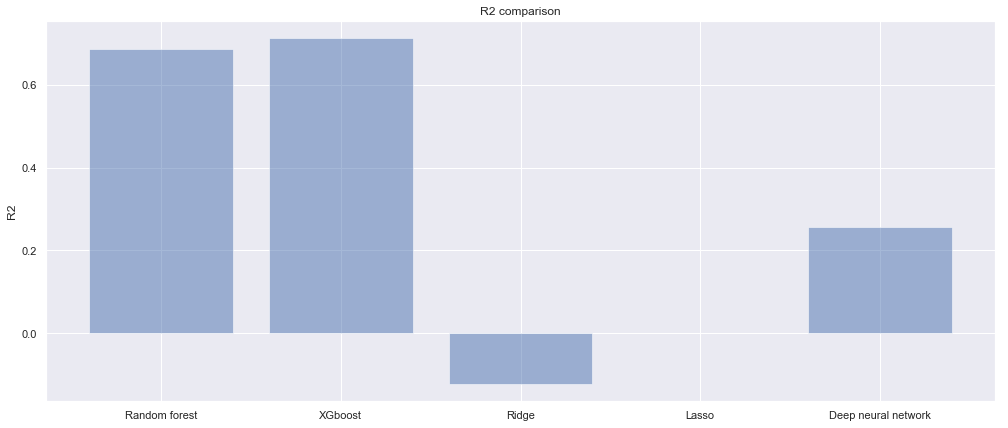

In [61]:
#model comparison by using R2
plt.figure(figsize=(17,7))
plt.bar(index, R2set,align='center', alpha=0.5)
plt.xticks(index, models)
plt.ylabel('R2')
plt.title('R2 comparison')

plt.show()

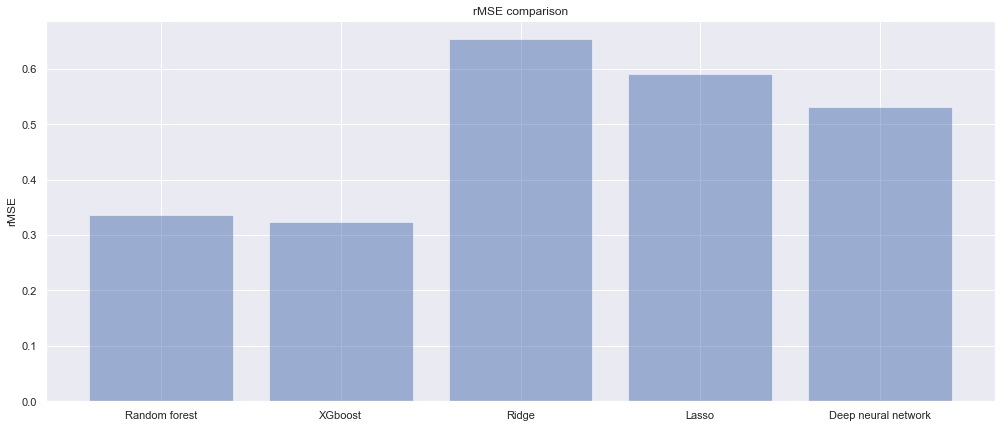

In [62]:
#model comparison by using rMSE

plt.figure(figsize=(17,7))
plt.bar(index, rMSEset,align='center', alpha=0.5)
plt.xticks(index, models)
plt.ylabel('rMSE')
plt.title('rMSE comparison')

plt.show()

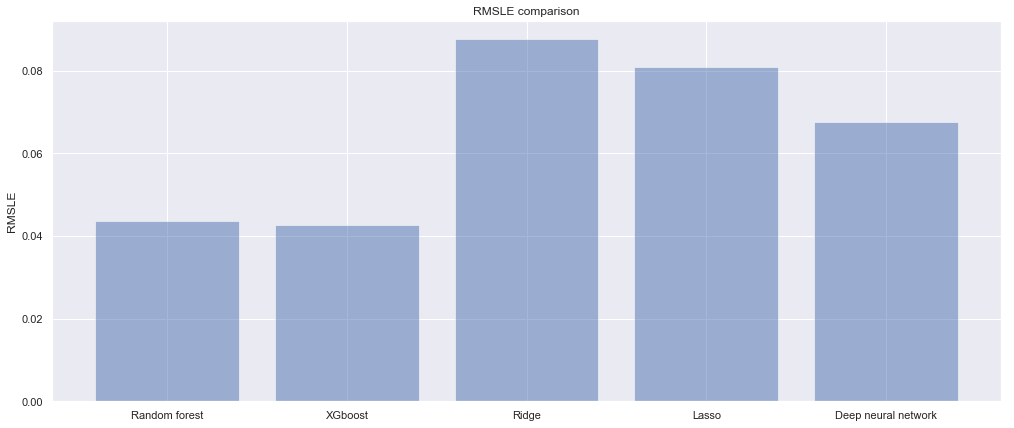

In [63]:
#model comparison by using RMSLE

plt.figure(figsize=(17,7))
plt.bar(index, RMSLEset,align='center', alpha=0.5)
plt.xticks(index, models)
plt.ylabel('RMSLE')
plt.title('RMSLE comparison')

plt.show()

**Comment:** For the first graph, XGboost and Random forest have good R2 scores. Ridge and Lasso have negative R2 which means they might perform worse than a linear model.

For the second graph and the third graph, the trends are similar, XGboost has the lowest RMSE/RMSLE and Ridge is still bad.

As a result, we could say XGboost is the best model here.

## 3. Deployment and Code Quality

Is the code well written with comments and descriptions?  
Is the code modular? Have you avoided repeating code and defined helpful functions or classes?